# Data Analysis - Mobility Project

## VENGEON Nicolas, 李想（Li Xiang), 徐振毅（Xu Zhenyi）

# Imports for the project

In [20]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from shapely.geometry import Point
from sklearn.preprocessing import MinMaxScaler
import math


# Import of project data + cleaning

In [2]:
mel_cities = gpd.read_file('2024-project/2024-project/cartographic-resources/mel_communes.zip')
nordData = gpd.read_file('2024-project/2024-project/cartographic-resources/IRIS-GE_2-0_SHP_LAMB93_D059-2020/IRIS_GE.SHX')
dfe = gpd.read_parquet('2024-project/2024-project/cartographic-resources/mel.parquet')
bruit = gpd.read_file('2024-project/2024-project/donnees-bruit-nuit.zip')

In [3]:
lilleMetropolis = nordData[nordData.INSEE_COM.isin(mel_cities['insee']) ]
lilleMetropolis = lilleMetropolis.to_crs(3950)
lilleMetropolis.reset_index(drop=True)
True

True

In [4]:
bruit = bruit.to_crs(3950)
bruit = bruit.reset_index(drop=True)


## Key variables

In [159]:
scoreDf = lilleMetropolis[['CODE_IRIS', 'geometry']].copy()

# Objectives: 

## Place a container near a bicycle lane in the most promising Irises. 
 ### Assign a score to each Iris based on:
- Noise level (The more, the better, to avoid quiet area)
- Proximity to business area (The closest, the better)
- Population density (The closest, the better)
 ### Selection of Iris
- Remove all the Iris where one of the score is too low (Eliminatory for the specified criterion)
- find the number x of containers to build based on the company budget
- Only keep the top x + 10 Iris, based on the agregation of their scores
- Chose x Iris in the list based of their best coverage of Lille metropolis area, considering bike time
 ### Place a container on each selected Iris, near a bycicle lane
 ------------------------------------------------------------------------------------------------------

# Assigning a score to each iris based on the noise level in the area.

## Map of noise in the Lille metropolitan area.

<Axes: title={'center': 'Map of Noise Levels in Lille Metropolis area'}>

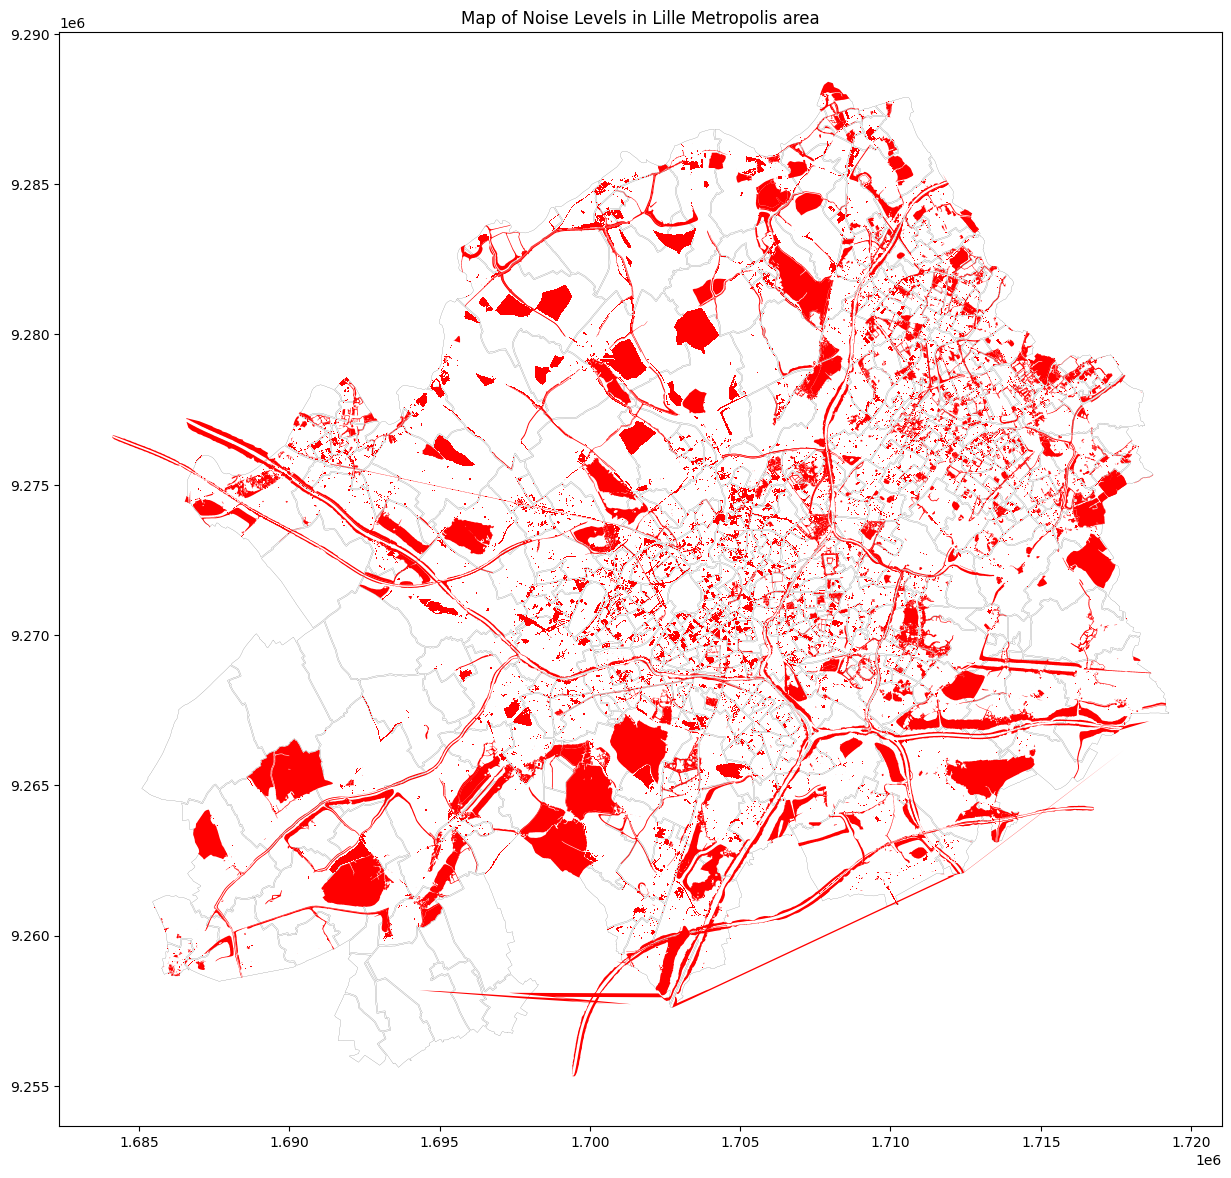

In [97]:
ax = lilleMetropolisBuffed.plot(color='white',edgecolor='black',linewidth=0.1,figsize=(15,15))
ax.set_title('Map of Noise Levels in Lille Metropolis area')
bruit.plot(ax=ax, color='red',linewidth=0.3,figsize=(15,15))

## Map of noise levels for each Iriss

### Aggregate all noise data by iris and calculate the geometric area of their intersection.




In [102]:
if 'noise' in lilleMetropolis.columns:
    lilleMetropolis.drop(columns=['noise'], inplace=True)
tempLille = lilleMetropolis.copy()
tempLille['surface_iris'] = tempLille.area

result = gpd.overlay(tempLille, bruit, how='intersection')
result['intersection_area'] = result.geometry
grouped_result = result.groupby('CODE_IRIS')['intersection_area'].apply(lambda x: x.unary_union).reset_index()

combined_geometries = gpd.GeoDataFrame(grouped_result, geometry='intersection_area')
tempLille = tempLille.merge(combined_geometries, how='left', on='CODE_IRIS')



### Add a new colmn on lilleMetropolis coresponding to the ratio of its area and the area off all the noise in the Iris

In [105]:
if 'noise' in lilleMetropolis.columns:
    lilleMetropolis.drop(columns=['noise'], inplace=True)
tempLille['noise'] = tempLille['intersection_area'].area / tempLille.geometry.area
tempLille['noise'] = tempLille['noise'].fillna(0)
lilleMetropolis = lilleMetropolis.merge(tempLille[['CODE_IRIS', 'noise']], how='left', on='CODE_IRIS')

### Ploting of the map, using a gradient

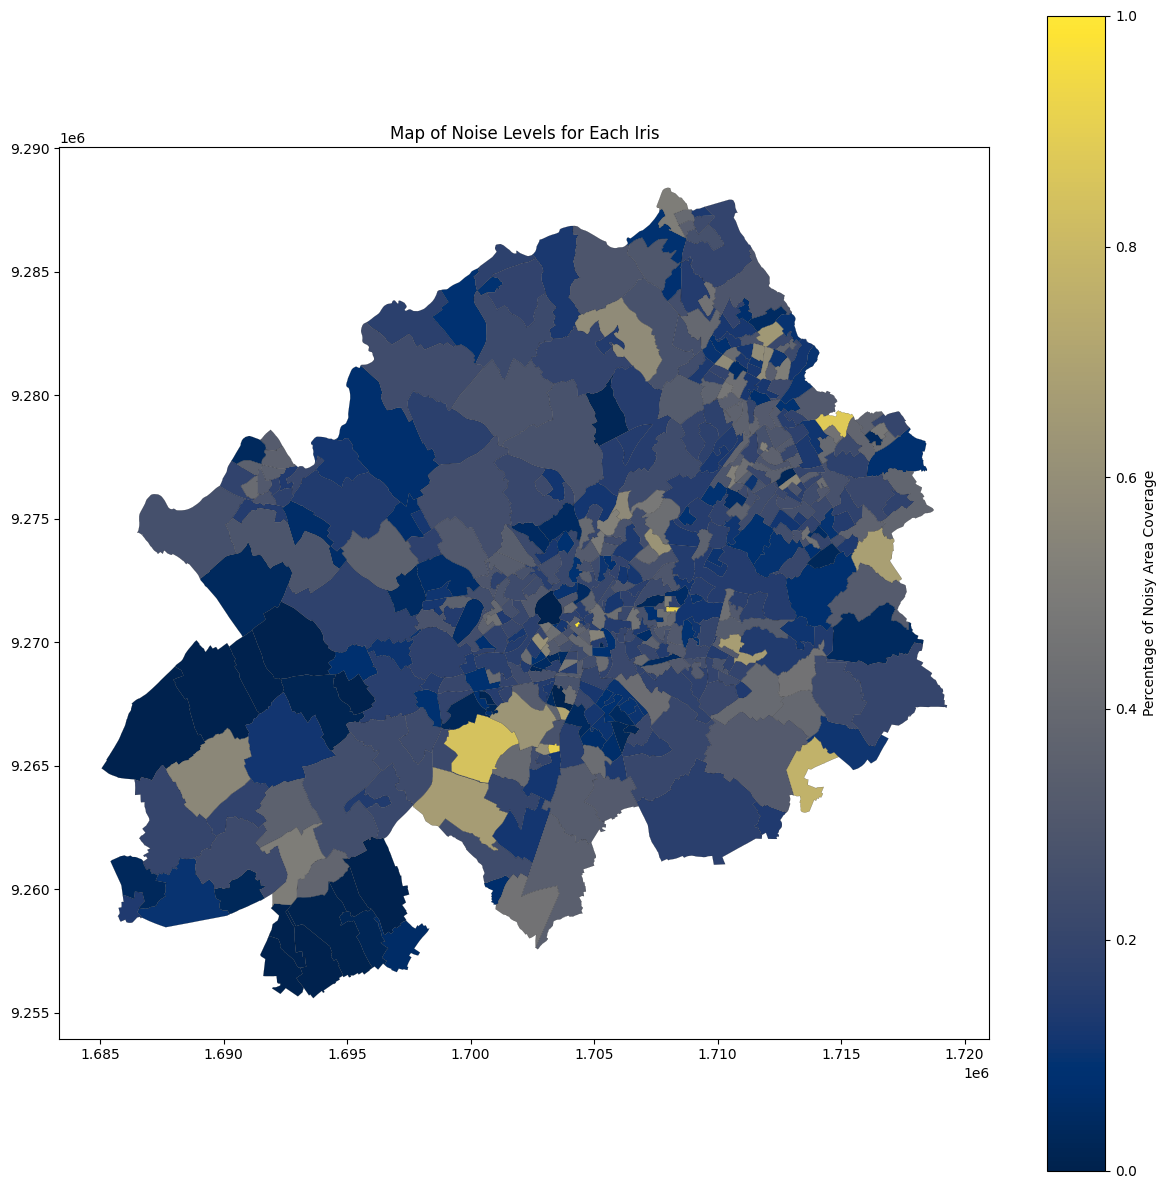

In [130]:
cmap = 'cividis'

norm = Normalize(vmin=0, vmax=1)
sm = ScalarMappable(cmap=cmap, norm=norm)

ax = lilleMetropolis.plot(column='noise', cmap=cmap, linewidth=0.1, edgecolor='black',
                                    legend=False, figsize=(15, 15))

cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Percentage of Noisy Area Coverage')
ax.set_title('Map of Noise Levels for Each Iris')

plt.show()

### Update the score of each Iris

In [168]:
scoreDf['Noise_level'] = lilleMetropolis['noise']

# Assigning a score to each iris based on their distance to business area

In [61]:
lilleMetropolis['Business_area'] = lilleMetropolis['TYP_IRIS'] == 'A'
lilleMetropolisBuffed = lilleMetropolis.copy()
lilleMetropolisBuffed.geometry = lilleMetropolisBuffed.geometry.apply(lambda g: g.buffer(-20))

In [89]:
def calculate_business_area_distance(iris, business_areas):
    if iris['Business_area']:
        return 0  # Iris dans la zone d'activité commerciale

    distances = iris['geometry'].distance(gpd.GeoSeries(business_areas))
    min_distance = distances.min()

    return min_distance

business_area_irises = lilleMetropolisBuffed[lilleMetropolisBuffed['TYP_IRIS'] == 'A']
lilleMetropolisBuffed['distanceArea'] = lilleMetropolisBuffed.apply(calculate_business_area_distance, axis=1, business_areas=business_area_irises['geometry'])

distances = lilleMetropolisBuffed['distanceArea'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0.6, 1))

non_one_mask = lilleMetropolisBuffed['distanceArea'] != 0
lilleMetropolisBuffed['Business_area_gradient'] = lilleMetropolisBuffed['distanceArea']
lilleMetropolisBuffed.loc[non_one_mask, 'Business_area_gradient'] = scaler.fit_transform(lilleMetropolisBuffed.loc[non_one_mask, 'distanceArea'].values.reshape(-1, 1))
lilleMetropolis['Business_area'] = 1- lilleMetropolisBuffed['Business_area_gradient']**2

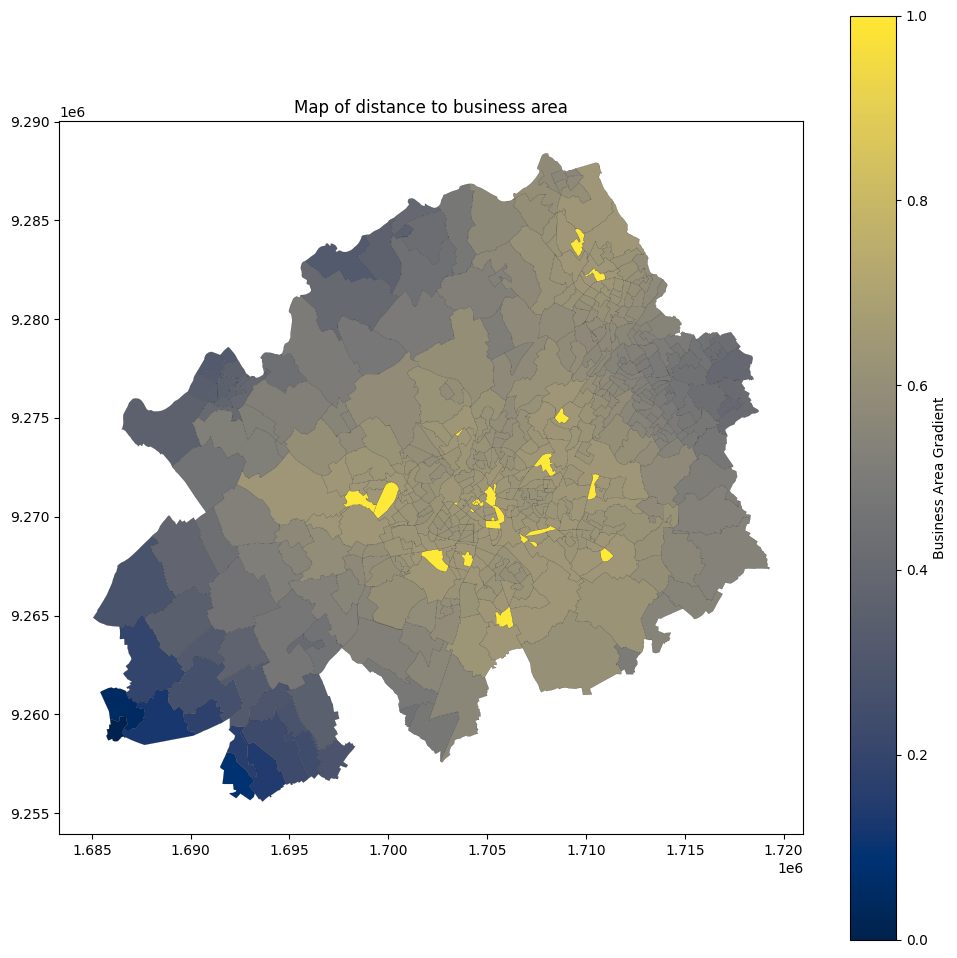

In [158]:

# Set up the colormap
cmap = 'cividis'
norm = Normalize(vmin=lilleMetropolis['Business_area'].min(),
                 vmax=lilleMetropolis['Business_area'].max())
sm = ScalarMappable(cmap=cmap, norm=norm)

# Plot the GeoDataFrame with a gradient of color
fig, ax = plt.subplots(figsize=(12, 12))
lilleMetropolis.plot(column='Business_area', cmap=cmap, linewidth=0.1, edgecolor='black',
                     legend=False, ax=ax)

# Add colorbar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Business Area Gradient')
ax.set_title('Map of distance to business area')

plt.show()


### Update the score of each Iris

In [163]:
scoreDf['Business_area'] = lilleMetropolis['Business_area']

# Assigning a score to each iris based on their population density

In [6]:
lilleMetropolis['superficie'] = lilleMetropolis['geometry'].area

In [13]:
lilleMetropolis['score_densite'] = 2000 / lilleMetropolis['superficie']

min_score_densite = lilleMetropolis['score_densite'].min()
max_score_densite = lilleMetropolis['score_densite'].max()
lilleMetropolis['score_densite_normalise'] = ((lilleMetropolis['score_densite'] - min_score_densite) / (max_score_densite - min_score_densite))**0.4



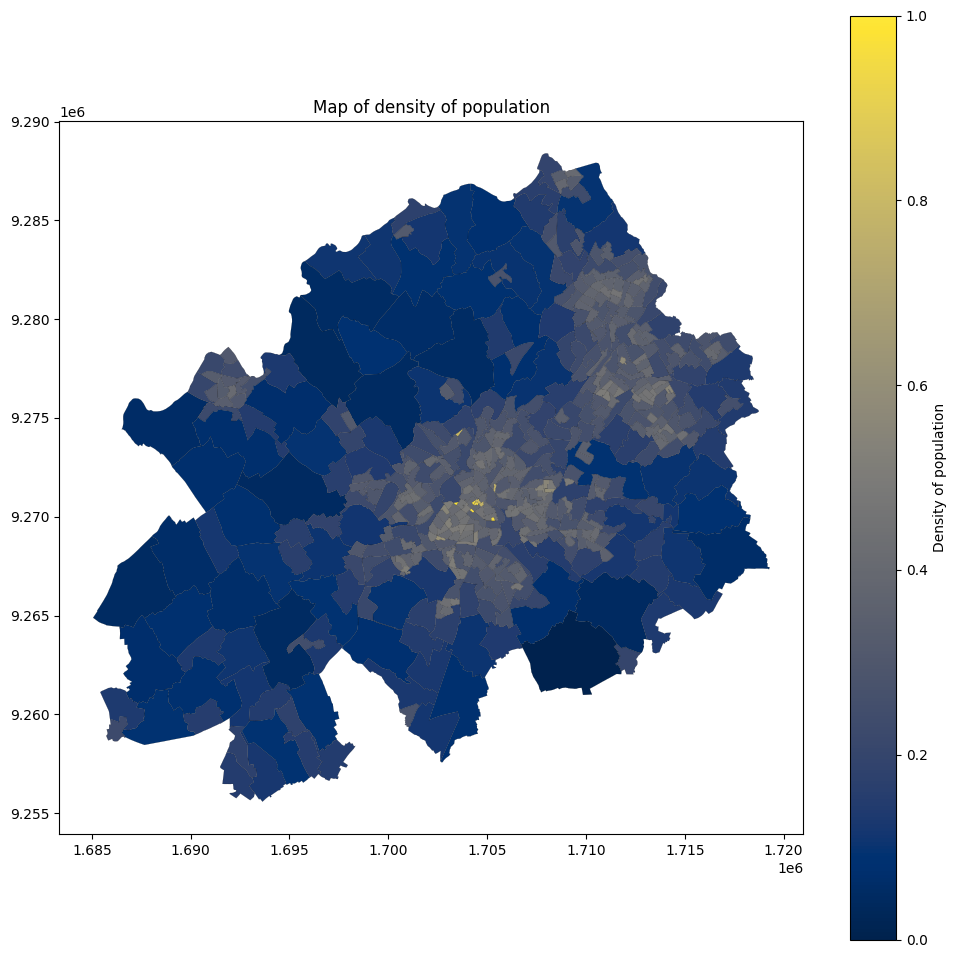

In [14]:

# Set up the colormap
cmap = 'cividis'
norm = Normalize(vmin=lilleMetropolis['score_densite_normalise'].min(),
                 vmax=lilleMetropolis['score_densite_normalise'].max())
sm = ScalarMappable(cmap=cmap, norm=norm)

# Plot the GeoDataFrame with a gradient of color
fig, ax = plt.subplots(figsize=(12, 12))
lilleMetropolis.plot(column='score_densite_normalise', cmap=cmap, linewidth=0.1, edgecolor='black',
                     legend=False, ax=ax)

# Add colorbar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Density of population')
ax.set_title('Map of density of population')

plt.show()


### Update the score of each Iris

In [173]:
scoreDf['population_density'] = lilleMetropolis['score_densite_normalise']

# Selection of Iries

## find the number x of containers to build based on the company budget

We consider the budget to be for 10 containers for the Lille metropolitan area

In [228]:
number_containers = 15

## Only keep the top x + 5 Iris, based on the agregation of their scores

In [115]:
scoreDf.columns

Index(['CODE_IRIS', 'geometry', 'Business_area', 'population_density',
       'Noise_level'],
      dtype='object')

In [224]:
IrisSelection['final_score'] = scoreDf['population_density'] +  3* scoreDf['Business_area'] + scoreDf['Noise_level']

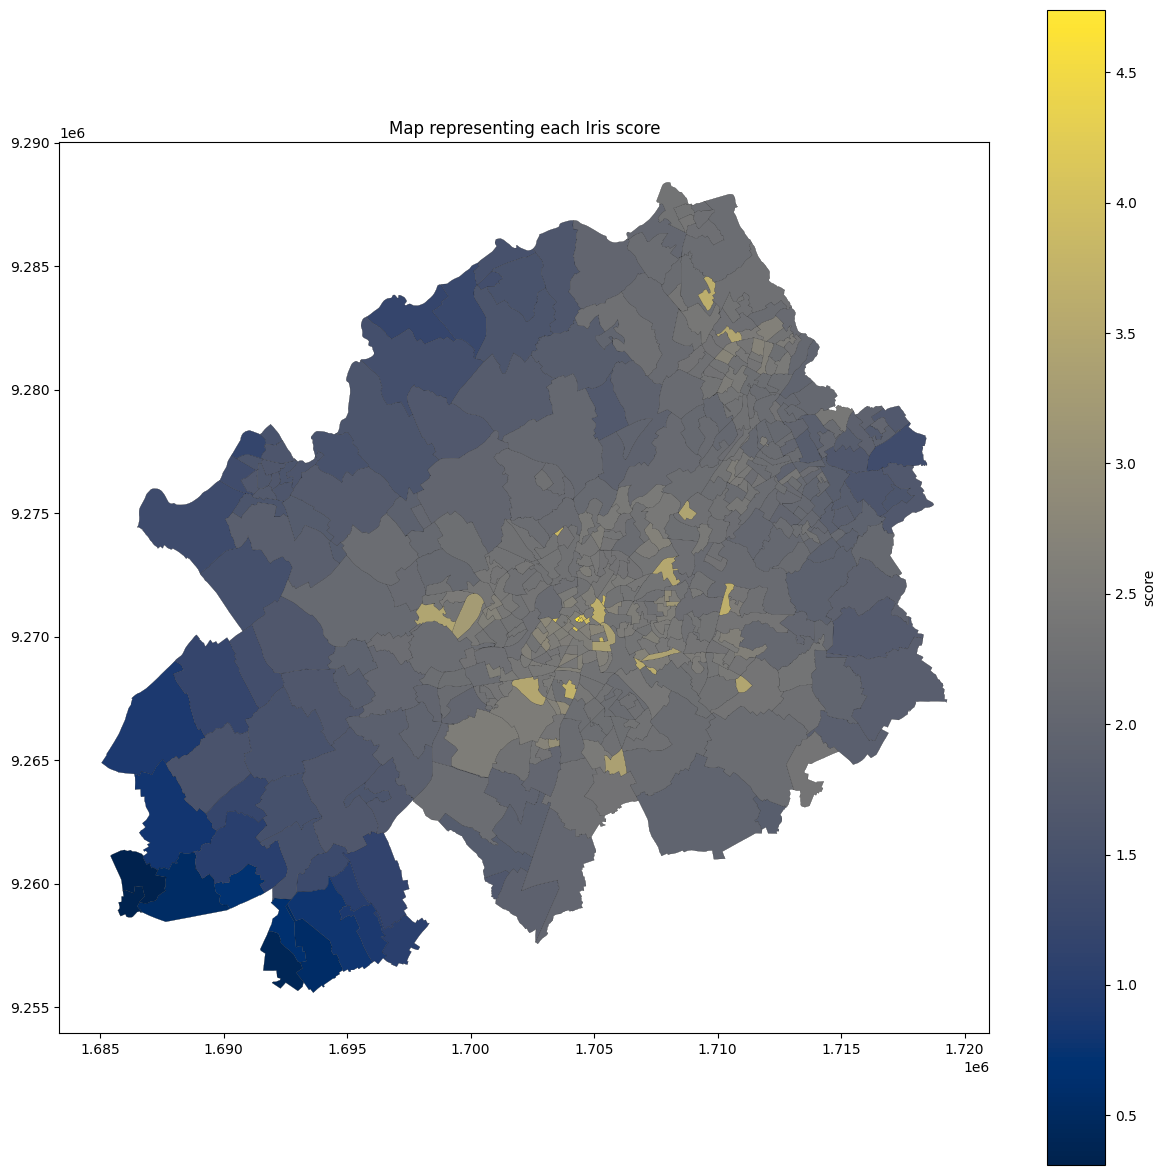

In [225]:

# Set up the colormap
cmap = 'cividis'
norm = Normalize(vmin=IrisSelection['final_score'].min(),
                 vmax=IrisSelection['final_score'].max())
sm = ScalarMappable(cmap=cmap, norm=norm)

# Plot the GeoDataFrame with a gradient of color
ax = lilleMetropolis.plot(color='white',edgecolor='black',linewidth=0.1,figsize=(15,15))

IrisSelection.plot(column='final_score', cmap=cmap, linewidth=0.1, edgecolor='black',
                     legend=False, ax=ax)

# Add colorbar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='score')
ax.set_title('Map representing each Iris score')

plt.show()


In [229]:
best_iris = IrisSelection.nlargest(number_containers + 10, 'final_score')


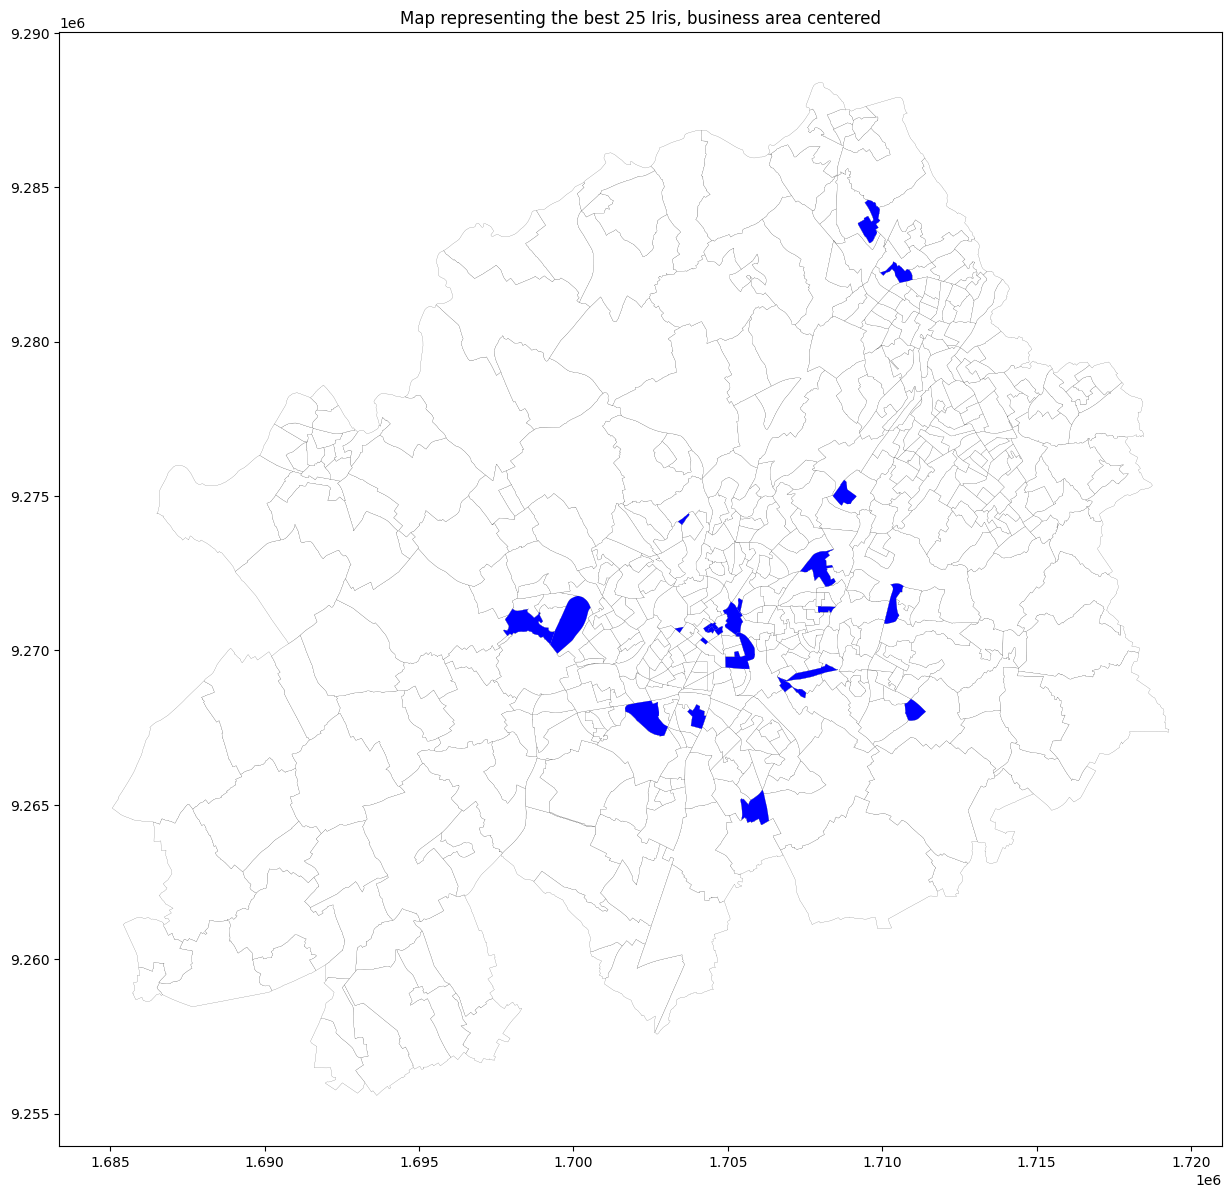

In [232]:

# Set up the colormap


# Plot the GeoDataFrame with a gradient of color
ax = lilleMetropolis.plot(color='white',edgecolor='black',linewidth=0.1,figsize=(15,15))

best_iris.plot(ax=ax,color='blue',linewidth=0.1)


# Add colorbar
ax.set_title('Map representing the best 25 Iris, business area centered')

plt.show()


# Chose x Iris in the list based of their best coverage of Lille metropolis area, considering bike time

## Algorithm for calculating bicycle travel time between two iris locations

In [239]:
dfe_bike = dfe[dfe['bicycle']>0].copy(deep=True)
dfe_bike = dfe_bike.dropna()
dfe_bike = dfe_bike[~(dfe_bike.is_empty | dfe_bike.geometry.isna())]
dfe_bike = dfe_bike.reset_index(drop=True)
dfe_bike.to_crs(3950)
True

True

In [240]:
average_speed_kph = 15
average_speed_mps = average_speed_kph * 1000 / 3600
dfe_bike['time'] = dfe_bike.length / average_speed_mps
lilleMetropolisBuffed = lilleMetropolis.to_crs(3950)
lilleMetropolisBuffed.geometry = lilleMetropolisBuffed.geometry.apply(lambda g: g.buffer(-20))

In [241]:
def find_nearest_bicycle_lane(index, graph):
    iris = lilleMetropolisBuffed['geometry'].loc[index]
    edges = graph.edges(data=True)
    
    nearest_lane = min(edges, key=lambda edge: iris.distance(edge[2]["geometry"]))
   # min_distance = iris.distance(nearest_lane[2]["geometry"])

    return (nearest_lane[0], nearest_lane[1]), nearest_lane[2]["geometry"]
